In [109]:
import os
import random as rnd
from collections import defaultdict

import nltk
import trax
from trax import layers as tl
from trax.supervised import training
from trax.fastmath import numpy as fastnp
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook

# Data preprocessing: from questions to tensors

In [11]:
data = pd.read_csv('train.csv.zip', index_col=0)
data.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [19]:
data_train, data_test = train_test_split(data, test_size=0.1)
data_train.shape

(363861, 5)

In [20]:
data_test.shape

(40429, 5)

In [48]:
td_index = data_train.index[data_train.is_duplicate == 1].tolist()

In [56]:
Q1_train_words = data_train.loc[td_index].question1.values
Q2_train_words = data_train.loc[td_index].question2.values

Q1_test_words = data_test.question1.values
Q2_test_words = data_test.question2.values
y_test  = data_test.is_duplicate.values

#create arrays
Q1_train = np.empty_like(Q1_train_words)
Q2_train = np.empty_like(Q2_train_words)

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

# Building the vocabulary with the train set         (this might take a minute)
vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in range(len(Q1_train_words)):
    Q1_train[idx] = nltk.word_tokenize(Q1_train_words[idx])
    Q2_train[idx] = nltk.word_tokenize(Q2_train_words[idx])
    q = Q1_train[idx] + Q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('The length of the vocabulary is: ', len(vocab))

for idx in range(len(Q1_test_words)): 
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

The length of the vocabulary is:  39279


In [57]:
# Converting questions to array of integers
for i in range(len(Q1_train)):
    Q1_train[i] = [vocab[word] for word in Q1_train[i]]
    Q2_train[i] = [vocab[word] for word in Q2_train[i]]

        
for i in range(len(Q1_test)):
    Q1_test[i] = [vocab[word] for word in Q1_test[i]]
    Q2_test[i] = [vocab[word] for word in Q2_test[i]]

In [58]:
Q1_train[0]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

# 

In [59]:
def Siamese(vocab_size=len(vocab), d_model=128, mode='train'):
    """Returns a Siamese model.

    Args:
        vocab_size (int, optional): Length of the vocabulary. Defaults to len(vocab).
        d_model (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        trax.layers.combinators.Parallel: A Siamese model. 
    """

    def normalize(x):  # normalizes the vectors to have L2 norm 1
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    q_processor = tl.Serial(  # Processor will run on Q1 and Q2.
        tl.Embedding(vocab_size, d_model), # Embedding layer
        tl.LSTM(d_model), # LSTM layer
        tl.Mean(axis=1), # Mean over columns
        tl.Fn('Normalize', lambda x: normalize(x))  # Apply normalize function
    )  # Returns one vector of shape [batch_size, d_model].
        
    # Run on Q1 and Q2 in parallel.
    model = tl.Parallel(q_processor, q_processor)
    return model

In [60]:
# Loading in the saved model
model = Siamese()
model.init_from_file('coursera_pretrained_siamese.pkl.gz')

/Users/louis.guitton/workspace/papers/venv/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [94]:
data_test = pd.read_csv('test.csv', index_col=0).fillna("")

In [96]:
Q1_test_words = data_test.question1.values
Q2_test_words = data_test.question2.values

Q1_test = np.empty_like(Q1_test_words)
Q2_test = np.empty_like(Q2_test_words)

for idx in tqdm(range(len(Q1_test_words))): 
    Q1_test[idx] = nltk.word_tokenize(Q1_test_words[idx])
    Q2_test[idx] = nltk.word_tokenize(Q2_test_words[idx])

for i in tqdm(range(len(Q1_test))):
    Q1_test[i] = [vocab[word] for word in Q1_test[i]]
    Q2_test[i] = [vocab[word] for word in Q2_test[i]]

100%|██████████| 2345796/2345796 [00:10<00:00, 223308.29it/s]


In [98]:
with open('question1_tensors.pickle', 'wb') as fh:
    pickle.dump(Q1_test, fh)

with open('question2_tensors.pickle', 'wb') as fh:
    pickle.dump(Q2_test, fh)

In [103]:
with open('question1_tensors.pickle', 'rb') as fh:
    b = pickle.load(fh)

assert (Q1_test == b).all()

In [104]:
def data_generator(Q1, Q2, batch_size, pad=1, shuffle=True):
    """Generator function that yields batches of data

    Args:
        Q1 (list): List of transformed (to tensor) questions.
        Q2 (list): List of transformed (to tensor) questions.
        batch_size (int): Number of elements per batch.
        pad (int, optional): Pad character from the vocab. Defaults to 1.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Yields:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [q1a, q2a, q3a, ...] i.e. (q1a,q1b) are duplicates
              input2: targets to your model [q1b, q2b,q3b, ...] i.e. (q1a,q2i) i!=a are not duplicates
    """

    input1 = []
    input2 = []
    idx = 0
    len_q = len(Q1)
    question_indexes = [*range(len_q)]
    
    if shuffle:
        rnd.shuffle(question_indexes)
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    while True:
        if idx >= len_q:
            # if idx is greater than or equal to len_q, set idx accordingly 
            # (Hint: look at the instructions above)
            idx = 0
            # shuffle to get random batches if shuffle is set to True
            if shuffle:
                rnd.shuffle(question_indexes)
        
        # get questions at the `question_indexes[idx]` position in Q1 and Q2
        q1 = Q1[question_indexes[idx]]
        q2 = Q2[question_indexes[idx]]
        
        # increment idx by 1
        idx += 1
        # append q1
        input1.append(q1)
        # append q2
        input2.append(q2)
        if len(input1) == batch_size:
            # determine max_len as the longest question in input1 & input 2
            # Hint: use the `max` function. 
            # take max of input1 & input2 and then max out of the two of them.
            max_len = max(max([len(l) for l in input1]), max([len(l) for l in input2]))
            # ceil to power-of-2 (Hint: look at the instructions above)
            max_len = 2**int(np.ceil(np.log2(max_len)))
            b1 = []
            b2 = []
            for q1, q2 in zip(input1, input2):
                # add [pad] to q1 until it reaches max_len
                q1 += [pad] * (max_len - len(q1))
                # add [pad] to q2 until it reaches max_len
                q2 += [pad] * (max_len - len(q2))
                # append q1
                b1.append(q1)
                # append q2
                b2.append(q2)
            # use b1 and b2
            yield np.array(b1), np.array(b2)
            # reset the batches
            input1, input2 = [], []  # reset the batches

In [139]:
batch_size=256
predictions = {}

for i in tqdm(range(0, len(Q1_test), batch_size), desc="batches"):
    # Call the data generator (built in Ex 01) with shuffle=False using next()
    # use batch size chuncks of questions as Q1 & Q2 arguments of the data generator. e.g x[i:i + batch_size]
    # Hint: use `vocab['<PAD>']` for the `pad` argument of the data generator
    q1, q2 = next(data_generator(
        Q1_test[i:i + batch_size], 
        Q2_test[i:i + batch_size], 
        batch_size, 
        pad=vocab['<PAD>'], 
        shuffle=False
    ))

    # Call the model
    v1, v2 = model((q1, q2))

    for j in range(batch_size):
        # take dot product to compute cos similarity of each pair of entries, v1[j], v2[j]
        # don't forget to transpose the second argument
        d = fastnp.dot(v1[j], v2[j].T)

        predictions[i + j] = float(d)

batches: 100%|██████████| 9164/9164 [2:44:54<00:00,  1.08s/it]   


In [140]:
data_test["similarity"] = pd.Series(predictions)

In [141]:
data_test.sort_values(by="similarity", ascending=False)

,question1,question2,similarity
test_id,,,
788812,Who invented the harp? What purpose does it se...,Who invented the marimba? What purpose does it...,1.000001
623887,How much money is spent during the 4 years in ...,How much money is spent during the 4 years in ...,1.000000
1668926,What is the corporate culture like at ARRIS Gr...,What is the corporate culture like at Radian G...,1.000000
86449,Is NH4NO3 soluble in water? Why or why not?,Is Hg2Cl2 soluble in water? Why or why not?,1.000000
449998,How do I register on www.edisha.gov.in?,How do I register on Rackons.com?,1.000000
...,...,...,...
1661148,Can the degree of a differential equation be a...,How is calculus used in the real world?,-0.418509
604158,What does media marketing vs search engine mar...,How can you look at someone's private Instagra...,-0.421759
1160733,Prisoner pardon blue red hat Google?,What can Adolf Hitler fight alongside Bavarian...,-0.434188


In [143]:
SCALE = data_train.is_duplicate.mean()

In [145]:
odds = data_test.similarity / (1 - data_test.similarity)
scaled_odds = SCALE * odds
scaled_odds / (1 + scaled_odds)

test_id
0          0.177522
1          0.282551
2          0.417358
3         -0.040349
4          0.108711
             ...   
2345791    0.183330
2345792    0.156098
2345793    0.133667
2345794    0.777241
2345795    0.033396
Name: similarity, Length: 2345796, dtype: float64

<AxesSubplot:>

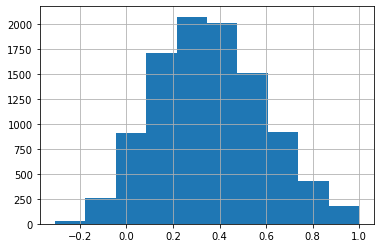

In [149]:
data_test.sample(10000).similarity.hist()

In [151]:
data_test["is_duplicate"] = data_test.similarity.clip(0, 1)

In [154]:
data_test.head()

,question1,question2,similarity,is_duplicate
test_id,,,,
0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...,0.368825,0.368825
1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?,0.516025,0.516025
2,What but is the best way to send money from Ch...,What you send money to China?,0.659785,0.659785
3,Which food not emulsifiers?,What foods fibre?,-0.117321,0.000000
4,"How ""aberystwyth"" start reading?",How their can I start reading?,0.248243,0.248243


In [155]:
data_test.is_duplicate.to_csv("siamese_lstm_network.csv.gz", compression='gzip')

In [158]:
!kaggle competitions submit \
    -f siamese_lstm_network.csv.gz \
    -m 'Siamese LSTM networks trained with triplet loss' \
    quora-question-pairs

100%|███████████████████████████████████████| 24.6M/24.6M [04:05<00:00, 105kB/s]
Successfully submitted to Quora Question Pairs